In [1]:
import bt
import FinanceDataReader as fdr
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import quantstats as qs
import seaborn as sns

# pd.options.display.float_format = '{:.4f}'.format
plt.style.use('ggplot') #ggplot
plt.rcParams['font.family'] = 'nanummyeongjo'
plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.grid'] = True

plt.rcParams['axes.formatter.useoffset'] = False
# plt.rcParmas['axes.formatter.limits'] = -1000, 1000

plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline
from IPython.display import display, HTML
"%config InlineBackend.figure_format = 'retina'"

#하나의 cell에서 multiple output을 출력을 가능하게 하는 코드
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# Pandas Dataframe의 사이즈가 큰 경우, 어떻게 화면에 출력을 할지를 세팅하는 코드
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('max_columns', None)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from strategy import*
from utils import *

prices는 현재 공휴일이 제외 되지 않았다. 

TODO:

1. 공휴일 제외 데이터를 만들어서(kospi기준) 백테스팅 필요

In [4]:
prices = pd.read_csv('data/dollar_assets.csv', index_col=0, parse_dates=True)
prices.head(1)

,달러,나스닥100,다우
Date,,,
2001-01-02,1278,2128.780,10646.150


In [6]:
def AMS(x):
    ''' x : Series (DataFrame의 컬럼)
        x[-1] : 기준일. x의 현재값
        (오늘날짜/과거날짜 - 1) > 0 보다 크면 1, 아니면 0
        => 오늘날짜/과거날짜 > 1 => 오늘날짜 > 과거날짜  => x[-1] > x
    '''
    # print(f"{list(np.where(x[-1]>x, 1, 0)[:-1])}, {len(np.where(x[-1]>x, 1, 0)[:-1])}")
    return np.mean(np.where(x[-1]>x, 1, 0)[:-1]) # 당일 날짜 비교는 제외해준다 [:-1]    

In [7]:
target_weights = pd.DataFrame()
for c in ["나스닥100", "다우"]:
    target_weights[c] = prices[c].rolling(365).apply(AMS)
target_weights = target_weights*0.5
target_weights['달러'] = 1.0 - target_weights.sum(axis=1)

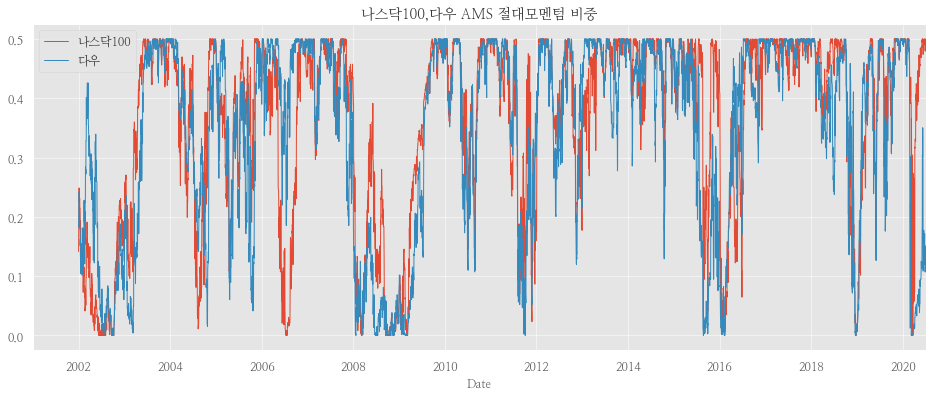

In [8]:
target_weights[['나스닥100', '다우']].plot(figsize=(16,6), title='나스닥100,다우 AMS 절대모멘텀 비중', legend=True);

In [9]:
tickers = prices.columns

In [13]:
나스닥다우동일비중 =bt.Strategy(
    "나스닥다우동일비중",
    [
        bt.algos.RunAfterDate('2002-1-2'),
        bt.algos.RunMonthly(),
        bt.algos.SelectThese(['나스닥100', '다우']),
        bt.algos.WeighEqually(),
#         bt.algos.PrintTempData(),
        bt.algos.Rebalance()
    ]
)

In [14]:
나스닥다우동일비중AMS = bt.Strategy(
    '나스닥다우동일비중AMS',
    [
        bt.algos.RunAfterDate('2002-1-2'),
        bt.algos.RunMonthly(),
        bt.algos.SelectThese(['나스닥100', '다우', '달러']),
        bt.algos.WeighTarget(target_weights),
        # WeighEquallyWithoutCash(target_weights, cash='현금'),
#         bt.algos.PrintTempData(),
        bt.algos.Rebalance()
    ]
)

In [15]:
bt_나스닥다우동일비중 = bt.Backtest(나스닥다우동일비중, prices)
bt_나스닥다우동일비중AMS = bt.Backtest(나스닥다우동일비중AMS,  prices)
r = bt.run(bt_나스닥다우동일비중, bt_나스닥다우동일비중AMS)

In [16]:
r.set_date_range("2002-02-01") 
r.display()

Stat                 나스닥다우동일비중    나스닥다우동일비중AMS
-------------------  --------------------  -----------------------
Start                2002-02-01            2002-02-01
End                  2020-07-02            2020-07-02
Risk-free rate       0.00%                 0.00%

Total Return         330.86%               214.80%
Daily Sharpe         0.41                  0.45
Daily Sortino        0.62                  0.68
CAGR                 8.25%                 6.43%
Max Drawdown         -52.74%               -17.10%
Calmar Ratio         0.16                  0.38

MTD                  0.95%                 0.93%
3m                   27.71%                8.31%
6m                   2.20%                 -3.13%
YTD                  3.60%                 -1.82%
1Y                   13.13%                5.44%
3Y (ann.)            14.20%                6.51%
5Y (ann.)            13.07%                5.39%
10Y (ann.)           14.90%                7.26%
Since Incep. (ann.)  8.25%            

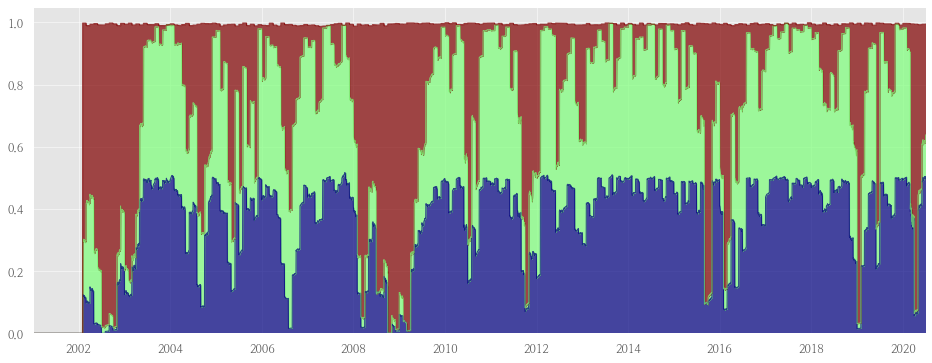

In [17]:
r.get_security_weights('나스닥다우동일비중AMS').plot.area(stacked=True, alpha=0.7, legend=False, cmap='jet', figsize=(16,6));

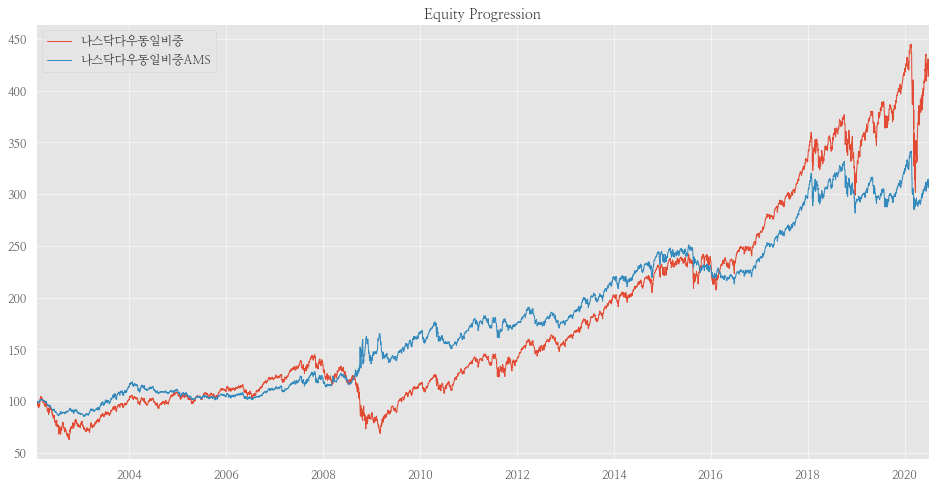

In [18]:
ax = r.plot(figsize=(16,8));
plt.legend(loc="upper left");

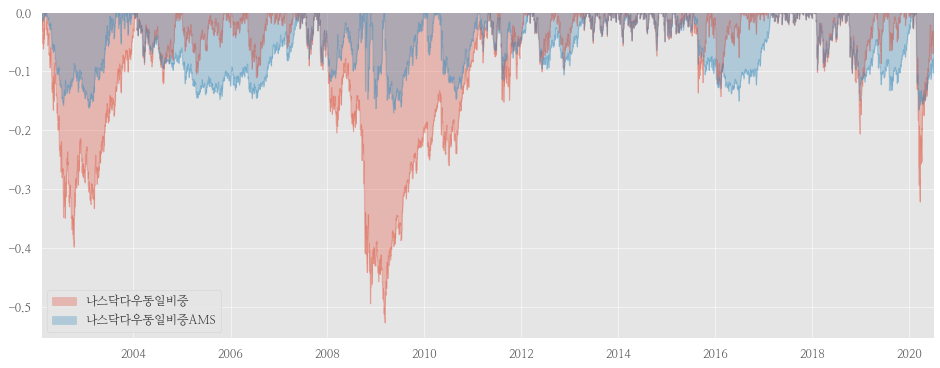

In [19]:
r.prices.to_drawdown_series().plot.area(stacked=False, alpha=0.3, figsize=(16, 6));